# Classification

In [78]:
import os
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [79]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, shuffle=True):
        """
        Custom dataset for loading 2D images from the specified folder structure.

        Parameters:
        - root_dir (str): The root directory containing subfolders for each class.
        - transform (callable, optional): Optional transform to be applied to the images.
        - shuffle (bool): If True, shuffle the order of images in the dataset.
        """
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.shuffle = shuffle

        self.filepaths, self.labels = self.load_dataset()

        if self.shuffle:
            self.shuffle_dataset()


    def load_dataset(self):
        filepaths = []
        labels = []
        for class_folder in self.classes:
            class_path = os.path.join(self.root_dir, class_folder)
            if os.path.isdir(class_path):
                for model_folder in os.listdir(class_path):
                    model_path = os.path.join(class_path, model_folder)
                    if os.path.isdir(model_path):
                        for filename in os.listdir(model_path):
                            filepath = os.path.join(model_path, filename)
                            filepaths.append(filepath)
                            labels.append(self.class_to_idx[class_folder])

        return filepaths, labels
    


    def shuffle_dataset(self):
        combined = list(zip(self.filepaths, self.labels))
        random.shuffle(combined)
        self.filepaths[:], self.labels[:] = zip(*combined)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)#.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label
    
    def plot_image(self, idx):
        """
        Plot the image at the specified index along with its label.

        Parameters:
        - idx (int): Index of the image in the dataset.
        """
        img, label = self.__getitem__(idx)

        # Convert tensor to numpy array
        img_np = img.permute(1, 2, 0).numpy()

        # Plot the image
        plt.imshow(img_np)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()



In [80]:
def split_dataset(dataset, test_size=0.2, random_state=42):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - dataset (Dataset): The dataset to be split.
    - test_size (float): The proportion of the dataset to include in the test split.
    - random_state (int): Seed for random state for reproducibility.

    Returns:
    - train_dataset (Dataset): Training set.
    - test_dataset (Dataset): Testing set.
    """
    train_indices, test_indices = train_test_split(
        range(len(dataset)),
        test_size=test_size,
        stratify=dataset.labels,  # Ensures proportional class distribution in train and test sets
        random_state=random_state
    )

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset



In [103]:
# Example usage:
root_directory = '../2d_data'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # Keep only the first three channels (R, G, B)
])

custom_dataset = CustomDataset(root_directory, transform=transform)

train_set, test_set = split_dataset(custom_dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [104]:
custom_dataset[0][0].shape

torch.Size([3, 224, 224])

In [105]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        # Modify the classifier head to match the number of classes in your dataset
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [117]:
# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the classifier
num_classes = len(custom_dataset.classes)
classifier = Classifier(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 10

In [123]:
# Lists to store training and test loss, and training and test accuracy values
train_loss_values = []
train_accuracy_values = []
test_loss_values = []
test_accuracy_values = []

# Training and testing loop
for epoch in range(num_epochs):
    # Training phase
    classifier.train()  # Set the model to training mode
    running_loss = 0.0
    predictions = []
    true_labels = []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
      
        optimizer.zero_grad()  # Zero the gradients
        outputs = classifier(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(true_labels, predictions)

    # Store training loss and accuracy values
    train_loss_values.append(running_loss / len(train_loader))
    train_accuracy_values.append(train_accuracy)

    # Print training loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss_values[-1]}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # Testing phase
    classifier.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Store test loss and accuracy values
    test_loss_values.append(test_running_loss / len(test_loader))
    test_accuracy_values.append(test_accuracy)

    # Print test loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss_values[-1]}, Test Accuracy: {test_accuracy * 100:.2f}%")


100%|██████████| 230/230 [01:24<00:00,  2.71it/s]


Epoch 1/10, Training Loss: 0.039773111670207154, Training Accuracy: 98.73%


100%|██████████| 58/58 [00:05<00:00, 10.45it/s]


Epoch 1/10, Test Loss: 0.17322203805991288, Test Accuracy: 94.99%


100%|██████████| 230/230 [00:36<00:00,  6.26it/s]


Epoch 2/10, Training Loss: 0.010390898275616801, Training Accuracy: 99.67%


100%|██████████| 58/58 [00:05<00:00, 11.26it/s]


Epoch 2/10, Test Loss: 0.12599256002858025, Test Accuracy: 95.86%


100%|██████████| 230/230 [00:32<00:00,  6.97it/s]


Epoch 3/10, Training Loss: 0.03639859358669997, Training Accuracy: 98.98%


100%|██████████| 58/58 [00:05<00:00, 11.24it/s]


Epoch 3/10, Test Loss: 0.3173878817208882, Test Accuracy: 90.80%


100%|██████████| 230/230 [00:33<00:00,  6.94it/s]


Epoch 4/10, Training Loss: 0.085228497959147, Training Accuracy: 97.36%


100%|██████████| 58/58 [00:05<00:00,  9.86it/s]


Epoch 4/10, Test Loss: 0.22704206358095438, Test Accuracy: 93.68%


100%|██████████| 230/230 [00:33<00:00,  6.96it/s]


Epoch 5/10, Training Loss: 0.0527524447450718, Training Accuracy: 98.18%


100%|██████████| 58/58 [00:05<00:00, 11.57it/s]


Epoch 5/10, Test Loss: 0.37912471936052217, Test Accuracy: 90.25%


100%|██████████| 230/230 [00:33<00:00,  6.96it/s]


Epoch 6/10, Training Loss: 0.08930671633494532, Training Accuracy: 97.00%


100%|██████████| 58/58 [00:05<00:00, 11.10it/s]


Epoch 6/10, Test Loss: 0.19261808510757342, Test Accuracy: 93.79%


100%|██████████| 230/230 [00:34<00:00,  6.61it/s]


Epoch 7/10, Training Loss: 0.0146076735047087, Training Accuracy: 99.58%


100%|██████████| 58/58 [00:06<00:00,  9.00it/s]


Epoch 7/10, Test Loss: 0.1341473300688386, Test Accuracy: 95.64%


100%|██████████| 230/230 [00:36<00:00,  6.25it/s]


Epoch 8/10, Training Loss: 0.00793135963194009, Training Accuracy: 99.81%


100%|██████████| 58/58 [00:06<00:00,  9.29it/s]


Epoch 8/10, Test Loss: 0.1406930489586024, Test Accuracy: 95.48%


100%|██████████| 230/230 [00:33<00:00,  6.79it/s]


Epoch 9/10, Training Loss: 0.01507016471912958, Training Accuracy: 99.55%


100%|██████████| 58/58 [00:05<00:00, 11.05it/s]


Epoch 9/10, Test Loss: 0.1259058970929894, Test Accuracy: 95.86%


100%|██████████| 230/230 [00:33<00:00,  6.93it/s]


Epoch 10/10, Training Loss: 0.014727918111732477, Training Accuracy: 99.50%


100%|██████████| 58/58 [00:05<00:00, 11.30it/s]

Epoch 10/10, Test Loss: 0.23911214874382933, Test Accuracy: 93.57%


In [124]:
# Evaluate the model on the test set
classifier.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Accuracy on the test set: 93.57%


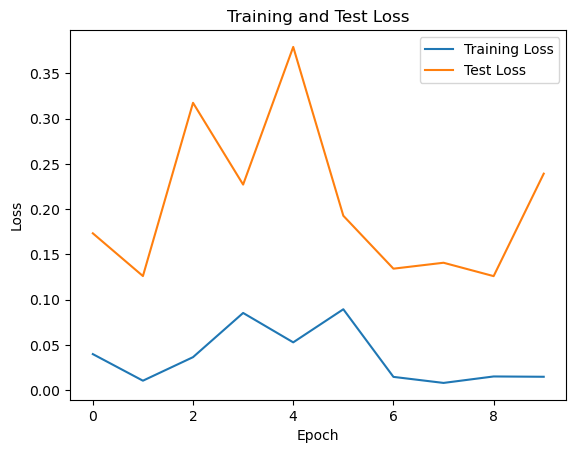

In [125]:
# Plot the learning curves
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

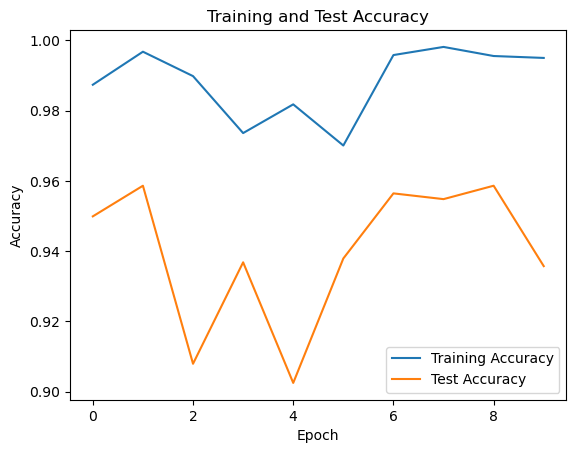

In [126]:
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()